# Extracting CTF values from specific points in a micrograph

First, we load the Patch CTF dataset as usual with CryoSPARC Tools. If any of this is unfamiliar to you, please
read the [README for this repo](https://github.com/cryoem-uoft/cryosparc-examples?tab=readme-ov-file#-how-do-i-use-these-scripts).

In [ ]:
from cryosparc.tools import CryoSPARC
from cryosparc.dataset import Dataset
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# prod-info.json is the same as instance-info.json
with open(Path('~/prod-info.json').expanduser(), 'r') as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
assert cs.test_connection()

# you'll need to change the project, workspace, and job uids here
project_uid = "P215"
project = cs.find_project(project_uid)
workspace_uid = "W7"

patch_ctf_juid = "J106"
patch_ctf_job = project.find_job(patch_ctf_juid)
mics = patch_ctf_job.load_output("exposures")

Next, we load the specific micrograph we care about with its UID. If you do not know the UID, you could find it using the path (or any other way), but you'll need to store its uid in the `micrograph_uid` variable before proceeding. It's used later to save the particle dataset.

In [ ]:
micrograph_uid = 12771648067724264282
micrograph = mics.query({"uid": micrograph_uid})[0]

In this block, we create the x and y coordinate grid over which we will sample the particles. **If you want to sample specific points** instead of a grid, replace `xi` with a list of x coordinates and `yi` with the corresponding y coordinate.

In [ ]:
spacing = np.arange(0, 1.1, 0.1)
xi, yi = np.meshgrid(spacing, spacing)

# to sample specific coordinates, in this case [0, 1] and [1, 2]
# xi = [0, 1]
# yi = [1, 2]

To create a dataset, we need to provide the *fields* and their *types*. We can get those by checking an existing dataset for the field types using `dataset.descr()`.

In [52]:
fields_of_interest = ["micrograph_blob/shape", "micrograph_blob/path", "ctf/exp_group_id", "micrograph_blob/psize_A"]
print("\n".join(f"{x[0].rjust(30)} {x[1]}" for x in micrograph.descr() if x[0] in fields_of_interest))

              ctf/exp_group_id <u4
          micrograph_blob/path |O
         micrograph_blob/shape <u4
       micrograph_blob/psize_A <f4


Here, we create the particle dataset. These dummy particles are just there to provide coordinates, but we still need to provide all of the fields that a particles dataset *location* requires.

In [ ]:
# create an empty dataset with the appropriate length and field names/types
ds = Dataset(len(xi.flatten()))
ds.add_fields(
    ["location/micrograph_uid", "location/center_x_frac", "location/center_y_frac", "location/micrograph_shape", "location/micrograph_path", "location/exp_group_id", "location/micrograph_psize_A"],
    ["u8", "f4", "f4", ("u4", 2), "O", "u4", "f4"]
)
ds["location/micrograph_uid"] = micrograph_uid # UID from earlier
ds["location/center_x_frac"] = xi.flatten() # particle X coordinates
ds["location/center_y_frac"] = yi.flatten() # particle Y coordinates
# the rest of these are included because we need them to find the CTF. they come from the micrograph itself.
ds["location/micrograph_shape"] = micrograph["micrograph_blob/shape"]
ds["location/micrograph_path"] = micrograph["micrograph_blob/path"]
ds["location/exp_group_id"] = micrograph["ctf/exp_group_id"]
ds["location/micrograph_psize_A"] = micrograph["micrograph_blob/psize_A"]

# save the dataset into CryoSPARC
ext_job_uid = project.save_external_result(
    workspace_uid,
    ds,
    "particle",
    "particles",
    ["location"]
)

Now we run a Patch CTF Extraction job to find each of our dummy particle's CTF.

In [27]:
lane = "cryoem6" # name of your CryoSPARC worker lane
ctf_extract = project.create_job(
    workspace_uid,
    "patch_ctf_extract",
    connections = {
        "exposures": (patch_ctf_juid, "exposures"),
        "particles": (ext_job_uid, "particles")
    }
)
ctf_extract.queue(lane)
ctf_extract.wait_for_done()

'completed'

Once the job is done, we can access the CTF values for each of the coordinates we create a dummy particle for and do whatever we like with them. In this case, I'll make a plot of the defocus landscape.

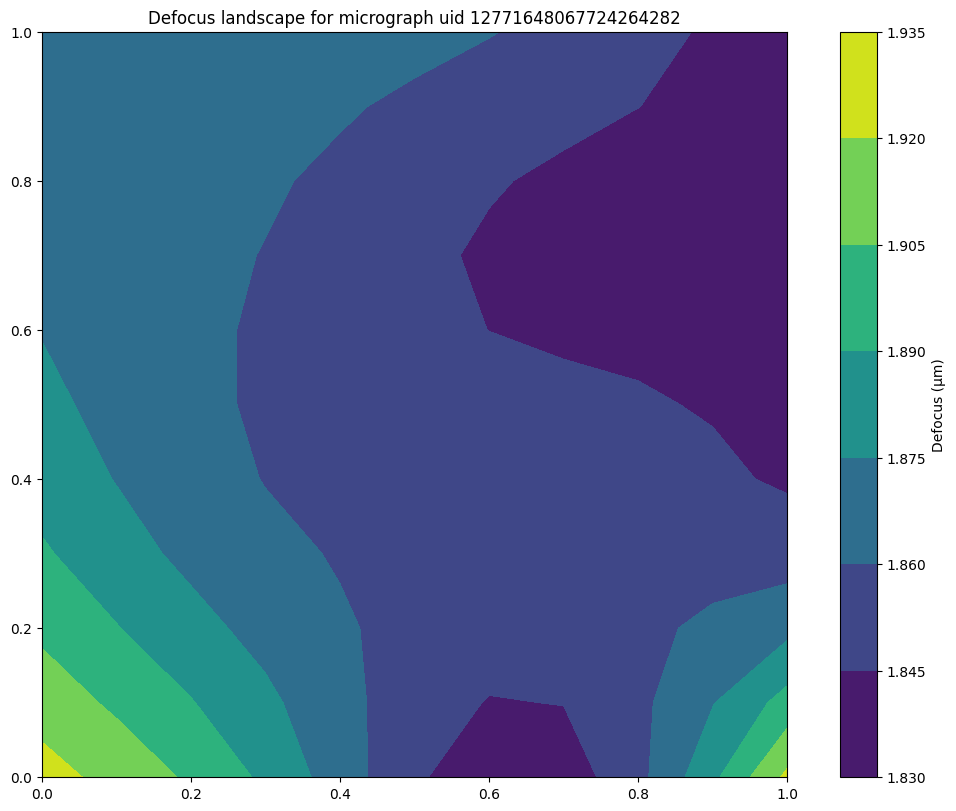

In [58]:
ctf_results = ctf_extract.load_output("particles")
fig, ax = plt.subplots(1, 1, figsize = (10, 8), frameon = False, layout = "constrained")
df_landscape = ax.contourf(
    xi,
    yi,
    (ctf_results["ctf/df1_A"] + ctf_results["ctf/df2_A"] / 2).reshape(xi.shape) / 10000
)
ax.set_aspect("equal")
cbar = fig.colorbar(df_landscape)
cbar.ax.set_ylabel("Defocus (µm)")
_ = ax.set_title(f"Defocus landscape for micrograph uid {micrograph_uid}")